In [1]:
import pandas as pd
import numpy as np
import warnings; warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt; plt.style.use('ggplot')
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, recall_score, f1_score,make_scorer, precision_score
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [2]:
# Load the dataset
data = pd.read_csv('land_utilization_dataset(1).csv')
print('The dimension of the dataset is:', data.shape)

The dimension of the dataset is: (1000, 8)


In [3]:
#drop null values
data.dropna(inplace=True)

#drop missing
print('The dimension of the dataset is after dropping null values:', data.shape)

The dimension of the dataset is after dropping null values: (1000, 8)


In [4]:
data.head()

,Area ID,Population Density (people per square kilometer),Current Housing Units,Available Land for Development (square kilometers),Maximum Sustainable Population Density (people per square kilometer),Zoning Type,Greenspace Area (square kilometers),y
0,1,1963,654,12.981758,1471,Commercial,0.416085,0
1,2,4606,2313,8.780754,3195,Mixed-Use,1.792054,0
2,3,2317,1046,16.992006,3354,Residential,0.659932,1
3,4,2737,717,-1.634290,1196,Commercial,4.623341,0
4,5,789,1370,12.372812,3418,Commercial,0.917030,1


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                                                                Non-Null Count  Dtype  
---  ------                                                                --------------  -----  
 0   Area ID                                                               1000 non-null   int64  
 1   Population Density (people per square kilometer)                      1000 non-null   int64  
 2   Current Housing Units                                                 1000 non-null   int64  
 3   Available Land for Development (square kilometers)                    1000 non-null   float64
 4   Maximum Sustainable Population Density (people per square kilometer)  1000 non-null   int64  
 5   Zoning Type                                                           1000 non-null   object 
 6   Greenspace Area (square kilometers)                                   1000 non-null   float64
 7  

In [6]:
le = LabelEncoder()

for col in data.columns:
    if data[col].dtype == 'object':
        data[col] =  le.fit_transform(data[col])

data.head()

,Area ID,Population Density (people per square kilometer),Current Housing Units,Available Land for Development (square kilometers),Maximum Sustainable Population Density (people per square kilometer),Zoning Type,Greenspace Area (square kilometers),y
0,1,1963,654,12.981758,1471,0,0.416085,0
1,2,4606,2313,8.780754,3195,1,1.792054,0
2,3,2317,1046,16.992006,3354,2,0.659932,1
3,4,2737,717,-1.634290,1196,0,4.623341,0
4,5,789,1370,12.372812,3418,0,0.917030,1


DATA EXPLORATION

In [7]:
round(100*data['y'].value_counts() / data.shape[0], 2)

1    51.6
0    48.4
Name: y, dtype: float64

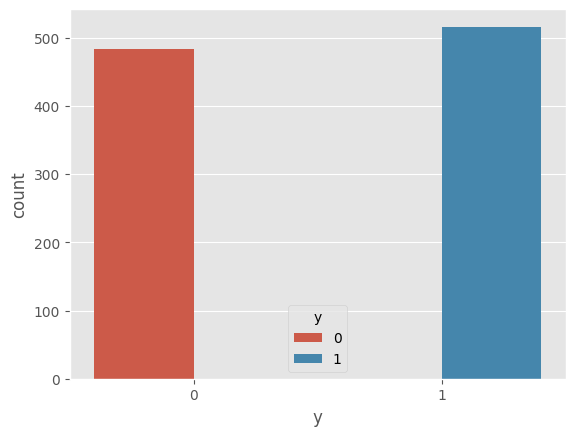

In [8]:
sns.countplot(x = 'y', hue = 'y', data = data);

In [9]:
X = data.drop(columns = ['y'])
y = data['y']

print(X.shape, y.shape)


(1000, 7) (1000,)


FEATURE ENGINEERING


In [10]:
# Scale the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [11]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)

In [13]:
# Hyperparameter tuning using GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_search = GridSearchCV(rf_classifier, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Print the best parameters found by GridSearchCV
print('Best Parameters:', grid_search.best_params_)

Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 150}


In [14]:
# Train the classifier with the best parameters
best_rf_classifier = RandomForestClassifier(random_state=42, **grid_search.best_params_)
best_rf_classifier.fit(X_train, y_train)

RandomForestClassifier(min_samples_split=5, n_estimators=150, random_state=42)

In [15]:
# Predictions
y_pred = best_rf_classifier.predict(X_test)

In [16]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print('Accuracy:', accuracy)
print('Confusion Matrix:\n', conf_matrix)
print('Classification Report:\n', class_report)

Accuracy: 0.965
Confusion Matrix:
 [[100   5]
 [  2  93]]
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.95      0.97       105
           1       0.95      0.98      0.96        95

    accuracy                           0.96       200
   macro avg       0.96      0.97      0.96       200
weighted avg       0.97      0.96      0.97       200



In [17]:
# Define evaluation metrics for cross-validation
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1_score': make_scorer(f1_score)
}

# Perform stratified k-fold cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_results = cross_validate(rf_classifier, X, y, cv=skf, scoring=scoring)

# Print cross-validation results
print('Cross-Validation Results:')
print('Mean Accuracy:', np.mean(cv_results['test_accuracy']))
print('Mean Precision:', np.mean(cv_results['test_precision']))
print('Mean Recall:', np.mean(cv_results['test_recall']))
print('Mean F1 Score:', np.mean(cv_results['test_f1_score']))


Cross-Validation Results:
Mean Accuracy: 0.9649999999999999
Mean Precision: 0.9634522691514922
Mean Recall: 0.9690440627333832
Mean F1 Score: 0.9661632806063111


In [18]:
#Save the model
import joblib

model_filename = "random_forest_model.pkl"
joblib.dump(best_rf_classifier, model_filename)


['random_forest_model.pkl']

In [20]:
def prediction(area_id, density, housing_units, available_land, max_density, greenspace, zoning_type):
    # Subtract greenspace area from available land
    available_land_after_greenspace = available_land - greenspace

    # Check if land is less than 0 or population exceeds maximum density
    if available_land_after_greenspace < 0 or density > max_density:
        return 0
    else:
        return 1
# Input from the user
area_id = int(input("Enter the Area ID: "))
density = float(input("Enter Population Density (people per square kilometer): "))
housing_units = int(input("Enter Current Housing Units: "))
available_land = float(input("Enter Available Land for Development (square kilometers): "))
max_density = float(input("Enter Maximum Sustainable Population Density (people per square kilometer): "))
greenspace = float(input("Enter Greenspace Area (square kilometers): "))
zoning_type = input("Enter Zoning Type: ")

# Call prediction function
result = prediction(area_id, density, housing_units, available_land, max_density, greenspace, zoning_type)

# Interpret the result
if result == 1:
    print("Land is available for development.")
else:
    print("Land is not available for development.")


Enter the Area ID: 1
Enter Population Density (people per square kilometer): 1000
Enter Current Housing Units: 345
Enter Available Land for Development (square kilometers): 34
Enter Maximum Sustainable Population Density (people per square kilometer): 2000
Enter Greenspace Area (square kilometers): 4
Enter Zoning Type: Residential
Land is available for development.
